SYSTEM REQUIREMENTS CHECK
pydub available: True
librosa available: True
FFmpeg available: True

Loading Sound Test.m4a...
Using pydub with FFmpeg for M4A file...
Successfully loaded!
Sample rate: 44100 Hz
Duration: 16.65 seconds
Number of samples: 734208


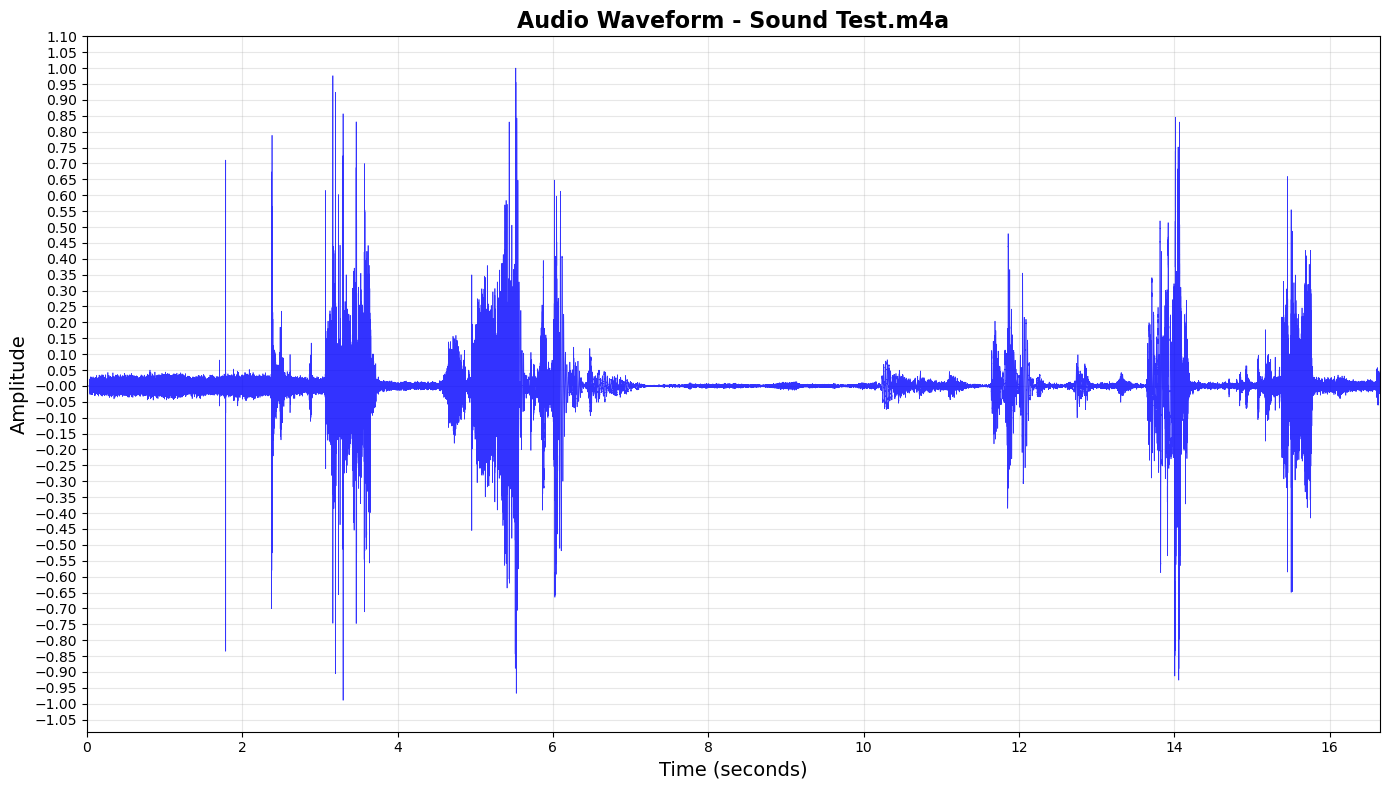

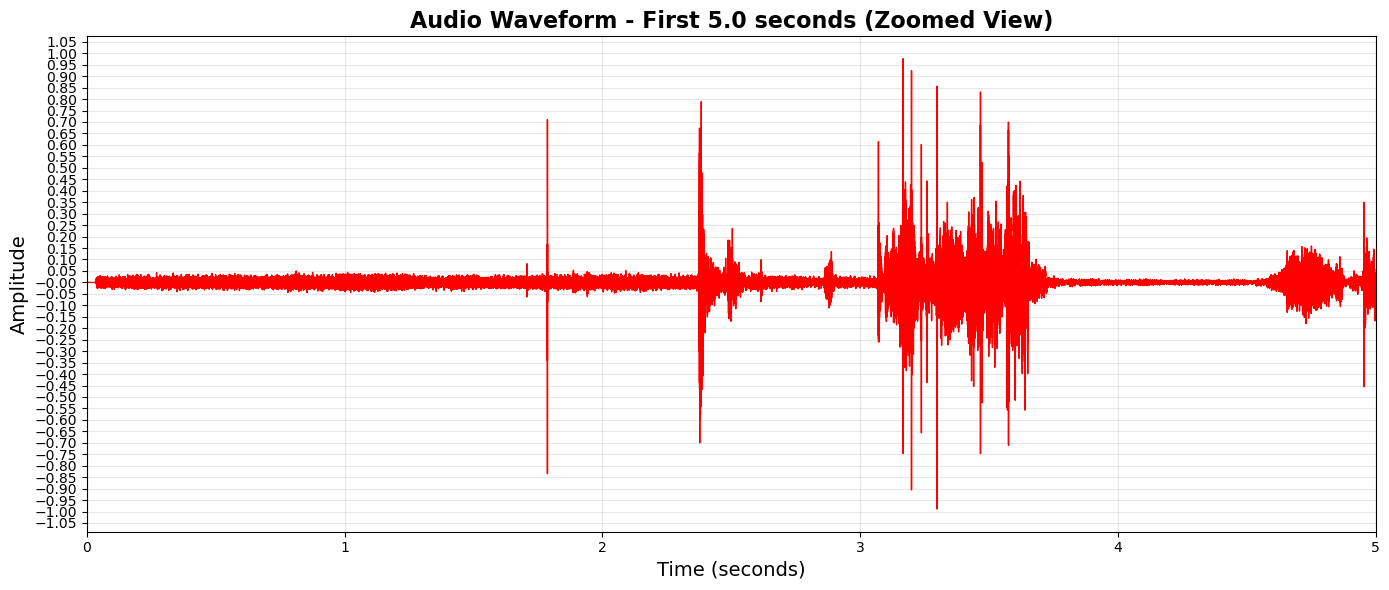


AUDIO FILE INFORMATION
File: Sound Test.m4a
Sample Rate: 44,100 Hz
Duration: 16.65 seconds
Total Samples: 734,208
Max Amplitude: 1.0000
RMS Amplitude: 0.0663
Dynamic Range: 23.56 dB

Waveform plot saved as 'waveform_Sound Test.png' with 0.05 amplitude increments


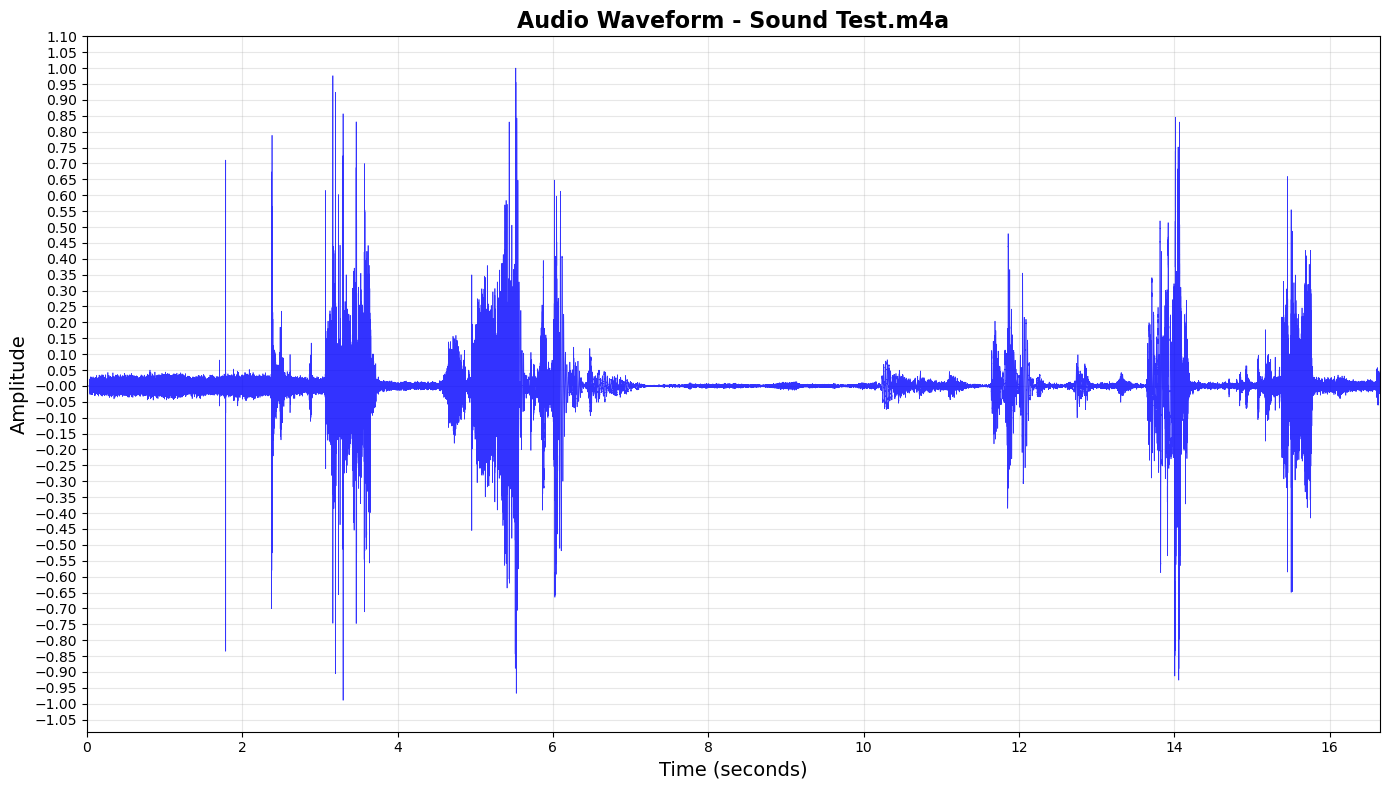

In [9]:
# Audio Waveform Visualization Script - M4A Compatible
# This script loads an M4A audio file and displays its waveform with proper axis labels

"""
INSTALLATION INSTRUCTIONS:

1. Install required Python packages:
   pip install pydub matplotlib numpy scipy

2. Install FFmpeg (required for M4A support):
   
   Windows:
   - Download FFmpeg from https://ffmpeg.org/download.html
   - Extract and add to PATH, OR
   - Use conda: conda install -c conda-forge ffmpeg
   
   Mac:
   - brew install ffmpeg
   
   Linux:
   - sudo apt install ffmpeg (Ubuntu/Debian)
   - sudo yum install ffmpeg (CentOS/RHEL)

Alternative: If you can't install FFmpeg, convert your M4A to WAV first using online converters
"""

import matplotlib.pyplot as plt
import numpy as np
import os
from scipy.io import wavfile
import warnings

# Try to import pydub for M4A support
try:
    from pydub import AudioSegment
    from pydub.utils import which
    PYDUB_AVAILABLE = True
except ImportError:
    PYDUB_AVAILABLE = False
    print("Warning: pydub not available. Install with: pip install pydub")

# Try to import librosa as backup
try:
    import librosa
    LIBROSA_AVAILABLE = True
except ImportError:
    LIBROSA_AVAILABLE = False
    print("Warning: librosa not available. Install with: pip install librosa")

def check_ffmpeg():
    """Check if FFmpeg is available for M4A processing"""
    return which("ffmpeg") is not None

def load_audio_pydub(audio_file):
    """Load audio using pydub (supports M4A with FFmpeg)"""
    try:
        # Load the audio file
        audio = AudioSegment.from_file(audio_file)
        
        # Convert to numpy array
        samples = np.array(audio.get_array_of_samples())
        
        # Handle stereo files
        if audio.channels == 2:
            samples = samples.reshape((-1, 2))
            # Convert to mono by averaging channels
            samples = samples.mean(axis=1)
        
        # Convert to float32 and normalize
        samples = samples.astype(np.float32)
        samples = samples / np.max(np.abs(samples))
        
        sample_rate = audio.frame_rate
        
        return samples, sample_rate
    
    except Exception as e:
        print(f"Error loading with pydub: {e}")
        return None, None

def load_audio_librosa(audio_file):
    """Load audio using librosa (fallback method)"""
    try:
        y, sr = librosa.load(audio_file, sr=None)
        return y, sr
    except Exception as e:
        print(f"Error loading with librosa: {e}")
        return None, None

def load_audio_scipy(audio_file):
    """Load audio using scipy (for WAV files only)"""
    try:
        sr, y = wavfile.read(audio_file)
        # Convert to float32 and normalize
        if y.dtype == np.int16:
            y = y.astype(np.float32) / 32768.0
        elif y.dtype == np.int32:
            y = y.astype(np.float32) / 2147483648.0
        elif y.dtype == np.uint8:
            y = (y.astype(np.float32) - 128) / 128.0
        
        # Handle stereo
        if len(y.shape) > 1:
            y = y.mean(axis=1)
            
        return y, sr
    except Exception as e:
        print(f"Error loading with scipy: {e}")
        return None, None

def visualize_audio_waveform(audio_file="Sound Test.m4a"):
    """
    Load and visualize audio waveform with proper axis labels
    """
    
    # Check if file exists
    if not os.path.exists(audio_file):
        print(f"Error: {audio_file} not found in current directory")
        print("Current directory contents:")
        audio_files = [f for f in os.listdir('.') if f.lower().endswith(('.m4a', '.mp3', '.wav', '.flac', '.aac'))]
        print(audio_files if audio_files else "No audio files found")
        return None, None
    
    print(f"Loading {audio_file}...")
    
    # Determine file extension
    file_ext = os.path.splitext(audio_file)[1].lower()
    
    y, sr = None, None
    
    # Try different loading methods based on file type and available libraries
    if file_ext == '.m4a':
        if PYDUB_AVAILABLE and check_ffmpeg():
            print("Using pydub with FFmpeg for M4A file...")
            y, sr = load_audio_pydub(audio_file)
        elif LIBROSA_AVAILABLE:
            print("Trying librosa for M4A file...")
            y, sr = load_audio_librosa(audio_file)
        else:
            print("Error: Neither pydub+FFmpeg nor librosa available for M4A files")
            print("Please install: pip install pydub")
            print("And install FFmpeg: https://ffmpeg.org/download.html")
            return None, None
    
    elif file_ext == '.wav':
        # Try scipy first for WAV files (faster)
        print("Using scipy for WAV file...")
        y, sr = load_audio_scipy(audio_file)
        if y is None and LIBROSA_AVAILABLE:
            print("Trying librosa for WAV file...")
            y, sr = load_audio_librosa(audio_file)
    
    else:
        # For other formats, try librosa
        if LIBROSA_AVAILABLE:
            print(f"Using librosa for {file_ext} file...")
            y, sr = load_audio_librosa(audio_file)
        else:
            print(f"Error: No suitable library available for {file_ext} files")
            return None, None
    
    if y is None or sr is None:
        print("Failed to load audio file with all available methods")
        print("\nTroubleshooting suggestions:")
        print("1. Convert M4A to WAV using online converter")
        print("2. Install FFmpeg: https://ffmpeg.org/download.html")
        print("3. Install pydub: pip install pydub")
        print("4. Install librosa: pip install librosa")
        return None, None
    
    print(f"Successfully loaded!")
    print(f"Sample rate: {sr} Hz")
    print(f"Duration: {len(y)/sr:.2f} seconds")
    print(f"Number of samples: {len(y)}")
    
    return y, sr

def plot_waveform(y, sr, audio_file="Sound Test.m4a"):
    """
    Create waveform plot with proper axis labels and 0.05 amplitude increments
    """
    # Create time axis for x-axis
    duration = len(y) / sr
    time = np.linspace(0, duration, len(y))
    
    # Create the waveform plot
    plt.figure(figsize=(14, 8))
    plt.plot(time, y, linewidth=0.5, alpha=0.8, color='blue')
    
    # Add labels and title
    plt.xlabel('Time (seconds)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Audio Waveform - {audio_file}', fontsize=16, fontweight='bold')
    
    # Set y-axis ticks with 0.05 amplitude increments
    y_min = np.min(y) * 1.1
    y_max = np.max(y) * 1.1
    y_ticks = np.arange(np.ceil(y_min/0.05)*0.05, np.floor(y_max/0.05)*0.05 + 0.05, 0.05)
    plt.yticks(y_ticks)
    
    # Add grid for better readability
    plt.grid(True, alpha=0.3)
    
    # Set axis limits
    plt.xlim(0, duration)
    plt.ylim(y_min, y_max)
    
    # Improve layout
    plt.tight_layout()
    
    # Show the plot
    plt.show()
    
    return time, duration

def plot_zoomed_waveform(y, sr, time, duration, zoom_seconds=5):
    """
    Create a zoomed-in view of the first few seconds with 0.05 amplitude increments
    """
    zoom_duration = min(zoom_seconds, duration)
    zoom_samples = int(zoom_duration * sr)
    
    plt.figure(figsize=(14, 6))
    plt.plot(time[:zoom_samples], y[:zoom_samples], linewidth=1.0, color='red')
    
    plt.xlabel('Time (seconds)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Audio Waveform - First {zoom_duration:.1f} seconds (Zoomed View)', 
              fontsize=16, fontweight='bold')
    
    # Set y-axis ticks with 0.05 amplitude increments for zoomed view
    y_zoom = y[:zoom_samples]
    y_min = np.min(y_zoom) * 1.1
    y_max = np.max(y_zoom) * 1.1
    y_ticks = np.arange(np.ceil(y_min/0.05)*0.05, np.floor(y_max/0.05)*0.05 + 0.05, 0.05)
    plt.yticks(y_ticks)
    
    plt.grid(True, alpha=0.3)
    plt.xlim(0, zoom_duration)
    plt.ylim(y_min, y_max)
    
    plt.tight_layout()
    plt.show()

def display_audio_info(y, sr, audio_file, duration):
    """
    Display detailed audio file information
    """
    print("\n" + "="*50)
    print("AUDIO FILE INFORMATION")
    print("="*50)
    print(f"File: {audio_file}")
    print(f"Sample Rate: {sr:,} Hz")
    print(f"Duration: {duration:.2f} seconds")
    print(f"Total Samples: {len(y):,}")
    print(f"Max Amplitude: {np.max(np.abs(y)):.4f}")
    print(f"RMS Amplitude: {np.sqrt(np.mean(y**2)):.4f}")
    print(f"Dynamic Range: {20 * np.log10(np.max(np.abs(y)) / (np.sqrt(np.mean(y**2)) + 1e-10)):.2f} dB")
    print("="*50)

def save_waveform_plot(y, sr, time, duration, audio_file="Sound Test.m4a"):
    """
    Save the waveform plot as a high-resolution image with 0.05 amplitude increments
    """
    plt.figure(figsize=(14, 8))
    plt.plot(time, y, linewidth=0.5, alpha=0.8, color='blue')
    plt.xlabel('Time (seconds)', fontsize=14)
    plt.ylabel('Amplitude', fontsize=14)
    plt.title(f'Audio Waveform - {audio_file}', fontsize=16, fontweight='bold')
    
    # Set y-axis ticks with 0.05 amplitude increments
    y_min = np.min(y) * 1.1
    y_max = np.max(y) * 1.1
    y_ticks = np.arange(np.ceil(y_min/0.05)*0.05, np.floor(y_max/0.05)*0.05 + 0.05, 0.05)
    plt.yticks(y_ticks)
    
    plt.grid(True, alpha=0.3)
    plt.xlim(0, duration)
    plt.ylim(y_min, y_max)
    plt.tight_layout()
    
    # Save the plot with high resolution
    output_filename = f'waveform_{os.path.splitext(audio_file)[0]}.png'
    plt.savefig(output_filename, dpi=300, bbox_inches='tight')
    print(f"\nWaveform plot saved as '{output_filename}' with 0.05 amplitude increments")
    plt.show()

def check_system_requirements():
    """
    Check what audio processing capabilities are available
    """
    print("SYSTEM REQUIREMENTS CHECK")
    print("="*40)
    print(f"pydub available: {PYDUB_AVAILABLE}")
    print(f"librosa available: {LIBROSA_AVAILABLE}")
    print(f"FFmpeg available: {check_ffmpeg()}")
    print("="*40)
    
    if not PYDUB_AVAILABLE and not LIBROSA_AVAILABLE:
        print("WARNING: No audio processing libraries available!")
        print("Install at least one: pip install pydub OR pip install librosa")
    
    if not check_ffmpeg():
        print("WARNING: FFmpeg not found!")
        print("For M4A support, install FFmpeg: https://ffmpeg.org/download.html")

# Main execution
if __name__ == "__main__":
    # Check system requirements
    check_system_requirements()
    print()
    
    # Load the audio file
    audio_file = "Sound Test.m4a"
    y, sr = visualize_audio_waveform(audio_file)
    
    if y is not None and sr is not None:
        # Plot the full waveform
        time, duration = plot_waveform(y, sr, audio_file)
        
        # Plot zoomed view (first 5 seconds)
        plot_zoomed_waveform(y, sr, time, duration, zoom_seconds=5)
        
        # Display audio information
        display_audio_info(y, sr, audio_file, duration)
        
        # Save the plot with 0.05 amplitude increments
        save_waveform_plot(y, sr, time, duration, audio_file)
    else:
        print("\nFailed to load audio file. Please check the troubleshooting suggestions above.")